In [1]:
import IPython
from torchfsdd import TorchFSDDGenerator, TrimSilence
from torchaudio.transforms import MFCC, TimeMasking, FrequencyMasking
from torchvision.transforms import Compose

from matplotlib import pyplot as plt

SAMPLING_RATE = 8e3  # 8kHz
N_MFCC_CHANNELS = 13  # Number of MFCC channels

# chop off silence from the beginning and end of the audio
trimmer = TrimSilence(threshold=1e-6)

mfcc = MFCC(sample_rate=SAMPLING_RATE, n_mfcc=N_MFCC_CHANNELS)

time_masking = TimeMasking(time_mask_param=2)
freq_masking = FrequencyMasking(freq_mask_param=2)

# Create a transformation pipeline to apply to the recordings
transforms = Compose([
    trimmer,
    mfcc,
])

# Fetch the latest version of FSDD and initialize a generator with those files
fsdd = TorchFSDDGenerator(version='master', transforms=None)

# Create a Torch dataset for the entire dataset from the generator
# full_set = fsdd.full()
# Create two Torch datasets for a train-test split from the generator
# train_set, test_set = fsdd.train_test_split(test_size=0.1)
# Create three Torch datasets for a train-validation-test split from the generator
train_set, val_set, test_set = fsdd.train_val_test_split(test_size=0.15, val_size=0.15)

In [2]:
data = test_set[1]


In [3]:
sample, label = data

IPython.display.Audio(sample.numpy(), rate=SAMPLING_RATE)

In [4]:


trimmed_sample = trimmer(sample)

#### Trimming silences
chunks of signal lower than threshold at the beginning and end are cut off

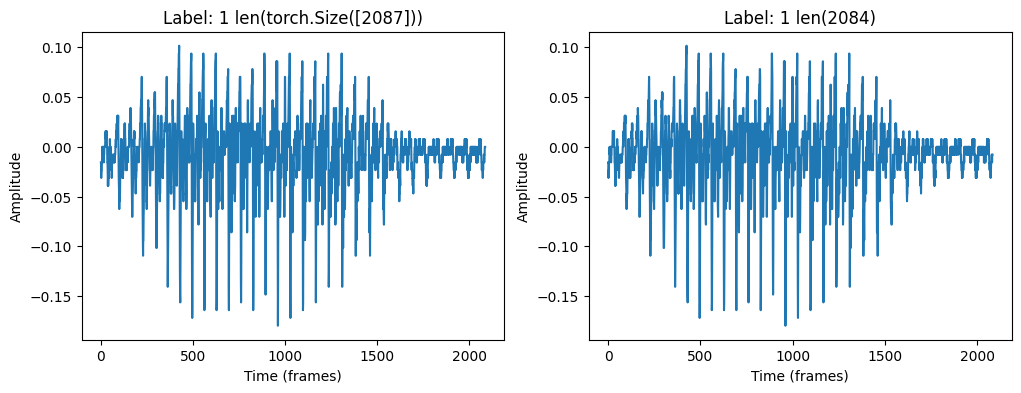

In [5]:

f, axs = plt.subplots(1, 2, figsize=(12, 4))
ax = axs[0]
ax.plot(sample,)
ax.set_title(f'Label: {label} len({sample.shape})')
ax.set_xlabel('Time (frames)')
ax.set_ylabel('Amplitude')
ax = axs[1]
ax.plot(trimmed_sample,)
ax.set_title(f'Label: {label} len({len(trimmed_sample)})')
ax.set_xlabel('Time (frames)')
ax.set_ylabel('Amplitude')
plt.show()

#### Mel Frequency Cepstral Coefficients (MFCC)
Shape of spectral envelope

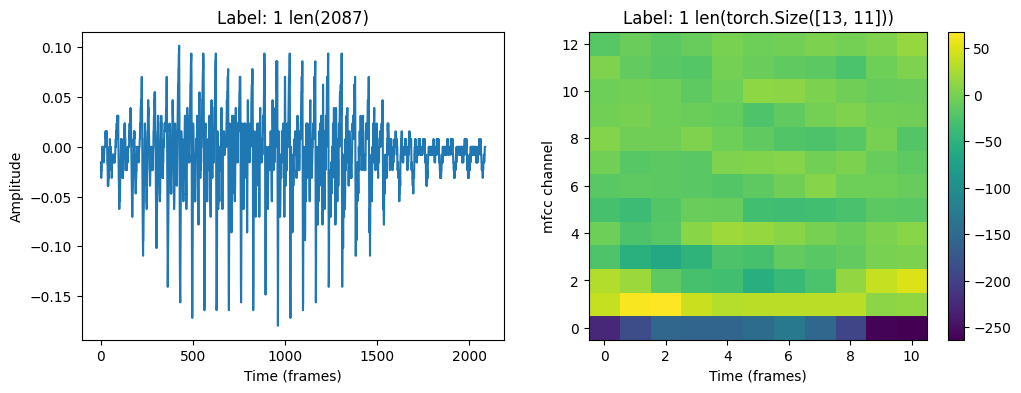

In [6]:
mfcc_sample = mfcc(sample)
f, axs = plt.subplots(1, 2, figsize=(12, 4))
ax = axs[0]
ax.plot(sample)
ax.set_title(f'Label: {label} len({len(sample)})')
ax.set_xlabel('Time (frames)')
ax.set_ylabel('Amplitude')
ax = axs[1]
im = ax.imshow(mfcc_sample, aspect='auto', origin='lower')
plt.colorbar(im, ax=ax)
ax.set_title(f'Label: {label} len({mfcc_sample.shape})')
ax.set_xlabel('Time (frames)')
ax.set_ylabel('mfcc channel')
plt.show()

#### Augmentation
Masking in a "channel" or a frame to enhance robustness

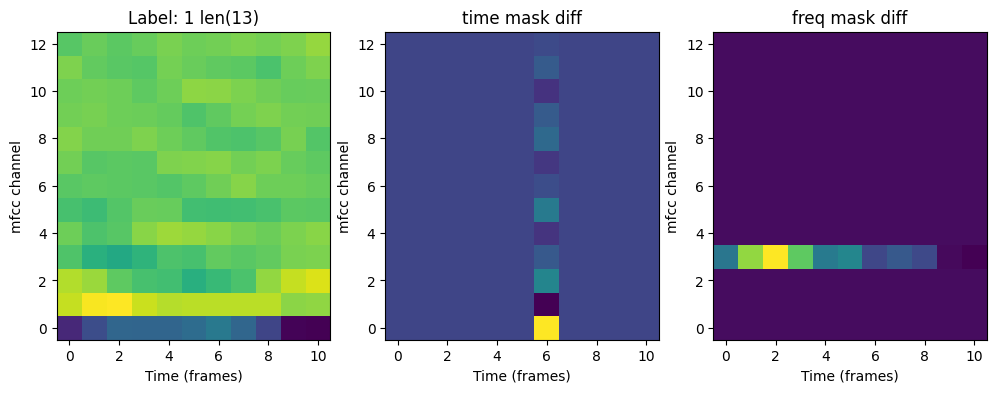

In [7]:
time_masked = time_masking(mfcc_sample)
freq_masked = freq_masking(mfcc_sample)

f, axs = plt.subplots(1, 3, figsize=(12, 4))
ax = axs[0]
ax.imshow(mfcc_sample, aspect='auto', origin='lower')
ax.set_title(f'Label: {label} len({len(mfcc_sample)})')
ax.set_xlabel('Time (frames)')
ax.set_ylabel('mfcc channel')
ax = axs[1]
ax.imshow(time_masked - mfcc_sample, aspect='auto', origin='lower')
ax.set_title(f'time mask diff')
ax.set_xlabel('Time (frames)')
ax.set_ylabel('mfcc channel')
ax = axs[2]
ax.imshow(freq_masked - mfcc_sample, aspect='auto', origin='lower')
ax.set_title(f'freq mask diff')
ax.set_xlabel('Time (frames)')
ax.set_ylabel('mfcc channel')
plt.show()


#### Normalize std
center data to zero mean and unit variance

tensor([ 8.6698e-08, -6.9087e-08,  3.2512e-08,  1.0837e-08,  2.1674e-08,
         2.3300e-07,  3.2512e-08,  1.0837e-08,  4.3349e-08,  2.7093e-08,
         1.6256e-08,  5.4186e-08,  2.7093e-08])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000])
tensor([ 9.5367e-07, -7.5996e-07,  3.5763e-07,  1.1921e-07,  2.3842e-07,
         2.5630e-06,  3.5763e-07,  1.1921e-07,  4.7684e-07,  2.9802e-07,
         1.7881e-07,  5.9605e-07,  2.9802e-07])


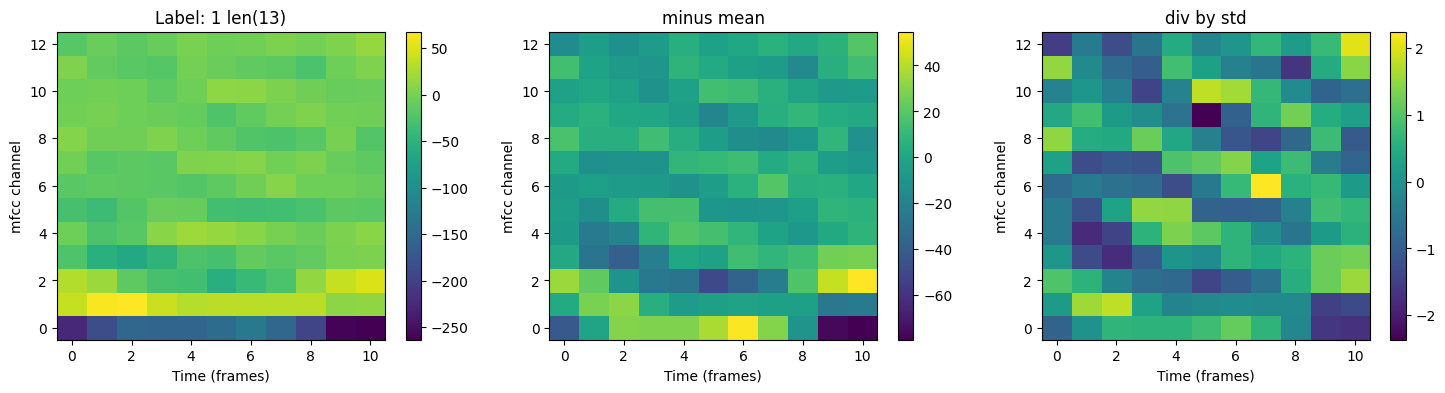

In [8]:
mean = mfcc_sample.mean(dim=1)
std = mfcc_sample.std(dim=1)
normalized_mfcc = (mfcc_sample - mean[:, None]) / (std[:, None] + 2e-30)
print(normalized_mfcc.mean(dim=1))
print(normalized_mfcc.var(dim=1))
print(normalized_mfcc.sum(dim=1))
f, axs = plt.subplots(1, 3, figsize=(18, 4))
ax = axs[0]
im = ax.imshow(mfcc_sample, aspect='auto', origin='lower')
plt.colorbar(im, ax=ax)
ax.set_title(f'Label: {label} len({len(mfcc_sample)})')
ax.set_xlabel('Time (frames)')
ax.set_ylabel('mfcc channel')

ax = axs[1]
im = ax.imshow(mfcc_sample - mean[:, None], aspect='auto', origin='lower')
plt.colorbar(im, ax=ax)
ax.set_title(f'minus mean')
ax.set_xlabel('Time (frames)')
ax.set_ylabel('mfcc channel')

ax = axs[2]
im = ax.imshow(normalized_mfcc, aspect='auto', origin='lower')
plt.colorbar(im, ax=ax)
ax.set_title(f'div by std')
ax.set_xlabel('Time (frames)')
ax.set_ylabel('mfcc channel')
plt.show()


### stats

In [9]:
import numpy as np


In [10]:

transformed_train = [transforms(x[0]) for x in train_set]


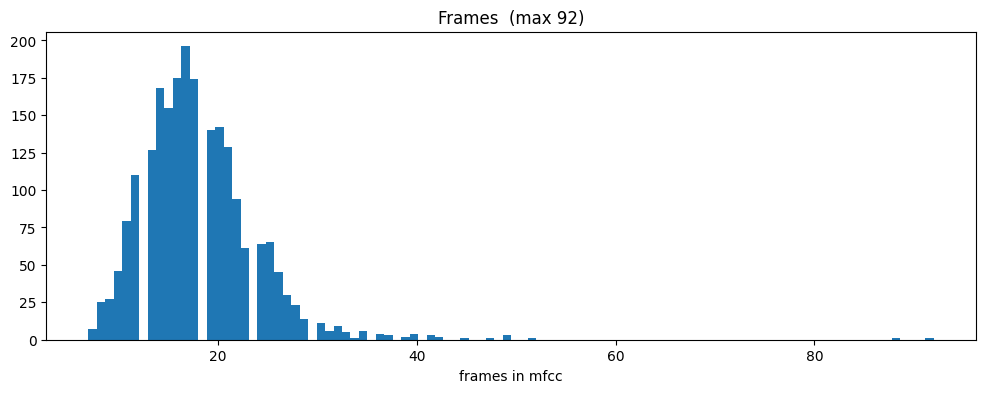

In [67]:
sizes = np.asarray([x.numel() for x in transformed_train])
widths = np.asarray([x.shape[1] for x in transformed_train])
max_width = widths.max()

f, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.hist(widths, bins=100)
ax.set_title(f'Frames  (max {widths.max()})')
ax.set_xlabel("frames in mfcc")

plt.show()

In [12]:
labels = np.asarray([x[1] for x in train_set])

In [13]:
indices_per_class = {class_id: np.where(labels == class_id)[0] for class_id in range(10)}

In [ ]:
averages = {}

for i, class_id in enumerate(range(10)):
    indices = indices_per_class[class_id]
    average = np.zeros((N_MFCC_CHANNELS, max_width))
    for s in range(len(indices)):
        index = indices[s]
        sample, _ = train_set[index]
        sample = transforms(sample)
        average[:, :sample.shape[1]] += sample.numpy()

    average /= len(indices)
    averages[class_id] = average



In [42]:
max_val = np.max([np.max(averages[class_id]) for class_id in range(10)])
min_val = np.min([np.min(averages[class_id]) for class_id in range(10)])

#### Average MFCC per class

They all look pretty similar, but do have some peaks here and there

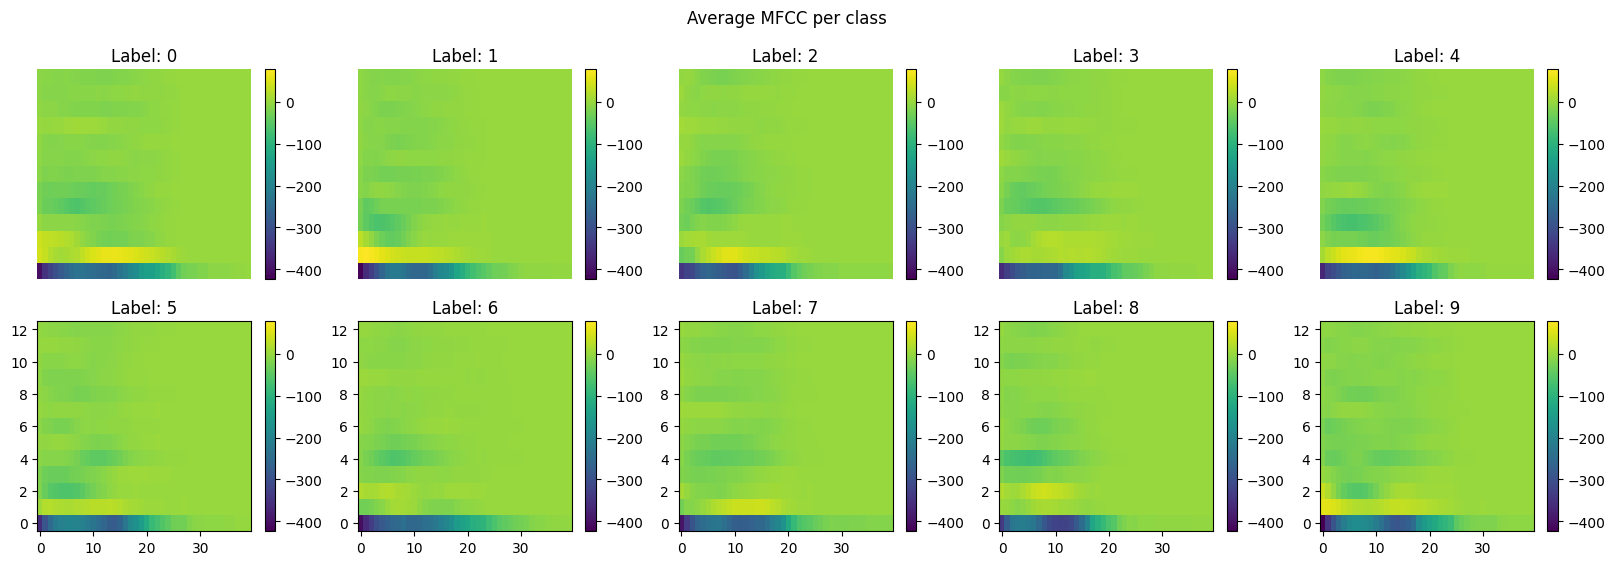

In [63]:
f, axs = plt.subplots(2, 5, figsize=(20, 6))
f.suptitle('Average MFCC per class')
axs = axs.flatten()
for i, class_id in enumerate(range(10)):
    average = averages[class_id]
    im = axs[i].imshow(average[:, :40],
                       aspect="auto",
                       interpolation="nearest",
                       origin="lower",
                       vmax=max_val,
                       vmin=min_val,
        )
    axs[i].set_title(f'Label: {class_id}')
    # axs[i * 2 + j].set_title(f'Label: {label} len({sample.shape})')
    # axs[i * 2 + j].set_xlabel('Time (frames)')
    # axs[i * 2 + j].set_ylabel('mfcc channel')
    if i < 5:
        axs[i].set_axis_off()
    plt.colorbar(im, ax=axs[i])
plt.show()

In [44]:
max_raw_length = np.max([len(x[0]) for x in train_set])

In [45]:
raw_same_length = np.asarray([np.pad(x[0].numpy(), (0, max_raw_length - len(x[0])), mode='constant') for x in train_set])

#### tSNE audio signals
Seems everyithing is mixed up, not easy to sepparate 

In [47]:
from sklearn.manifold import TSNE
print(raw_same_length.shape)
raw_embedded = TSNE(n_components=2).fit_transform(raw_same_length)
print(raw_embedded.shape)

(2160, 18262)
(2160, 2)


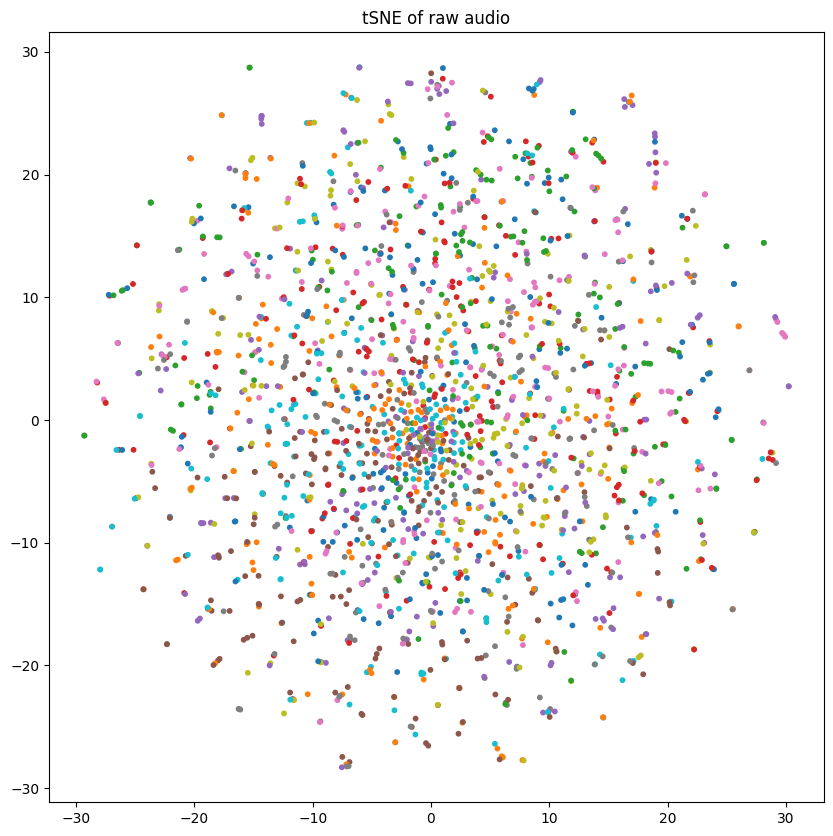

In [64]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(raw_embedded[:, 0], raw_embedded[:, 1], c=labels, s=10, cmap="tab10")
ax.set_title(f'tSNE of raw audio')
plt.show()

In [53]:
mfcc_same_length = []
for sample in transformed_train:
    same_leght = np.zeros((N_MFCC_CHANNELS, max_width))
    same_leght[:, :sample.shape[1]] = sample.numpy()
    mfcc_same_length.append(same_leght.flatten())
mfcc_same_length = np.asarray(mfcc_same_length)
print(mfcc_same_length.shape)


(2160, 1196)


#### tSNE MFCC
Locally clustered, probably easier to sepparate

In [54]:
mfcc_embedded = TSNE(n_components=2).fit_transform(mfcc_same_length)
print(mfcc_embedded.shape)

(2160, 2)


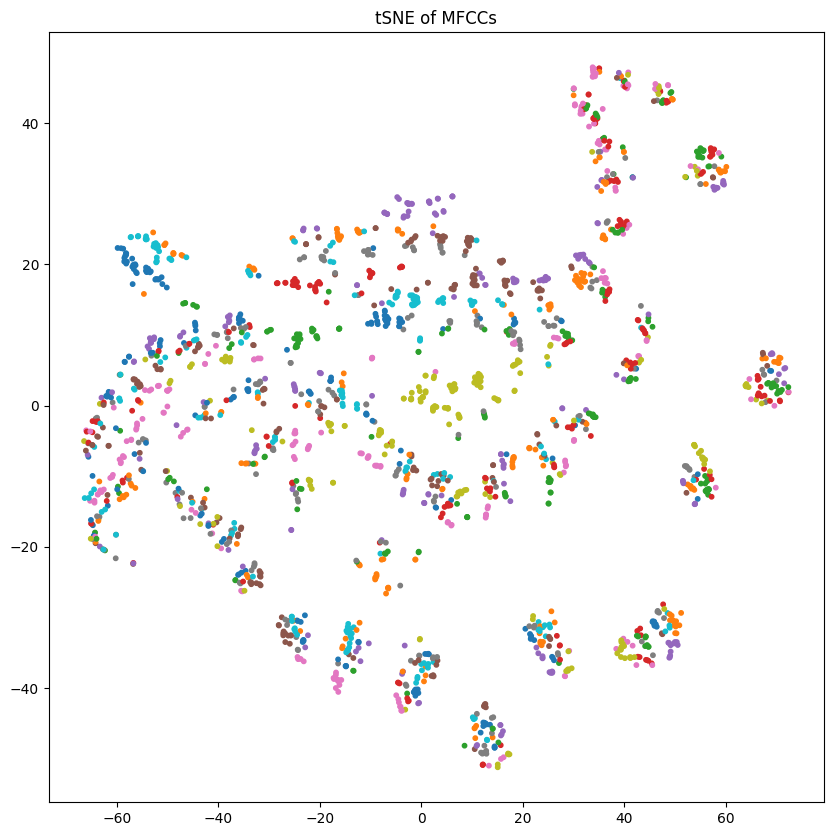

In [65]:
f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(mfcc_embedded[:, 0], mfcc_embedded[:, 1], c=labels, s=10, cmap="tab10")
ax.set_title(f'tSNE of MFCCs')
plt.show()